Code to generate the distributions of each of the models to validate their outputs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
from scipy import stats, integrate
from functools import partial
import math

In [2]:
def GBM(mu,sigma,T,s0):
    t= np.linspace(0,T,100)
    step = T/len(t)
    stock = s0
    for i in range(len(t)):
      z = np.random.normal(0,1)
      stock = stock * np.exp((mu- 0.5 * sigma**2)*step + sigma*np.sqrt(step)*z)
    return stock


#This is the distribution that the CTMC model would have if behaved like originally thought however is not he case
def GBM_SD(mu,sigmas,T,s0):
    t= np.linspace(0,T,100)
    step = T/len(t)
    stock = s0
    sigma = np.random.choice(sigmas,p=[2/3,1/3])
    for i in range(len(t)):
      z = np.random.normal(0,1)
      stock = stock * np.exp((mu- 0.5 * sigma**2)*step + sigma*np.sqrt(step)*z)
    return stock


def GBM_WS(mu,sigmas,T,s0,Q):
    t = np.linspace(0, T*100, 1000) # np.linspace(0, T*5000, 50000)
    step = T/len(t)
    stock = s0
    states = list(range(len(Q)))
    current = np.random.choice(states,p=[2/3,1/3]) 
    sigma = sigmas[current]
    z = np.random.exponential(1 / abs(Q[current][current]))
    length = 0

    for i in range(len(t)):
        length += step
        if length >= z:
            length = 0
            p = Q[current] / abs(Q[current][current]) 
            probs = [pr if pr >= 0 else 0 for pr in p]
            current = np.random.choice(states, p=probs)
            sigma = sigmas[current]
            z = np.random.exponential(1 / abs(Q[current][current]))
        eta = np.random.normal(0, 1)
        stock = stock * np.exp((mu- 0.5 * sigma**2)*step + sigma*np.sqrt(step)*eta)
    return stock

def Stochastic_Volatility(mu,sig0,T,s0,delta,theta,k):
    sigma = sig0
    t= np.linspace(0,T,100)
    step=T/len(t)
    stock = s0
    rho=0.6
    for i in range(len(t)):
      Z = np.random.multivariate_normal(np.array([0,0]), cov = np.array([[1,rho],[rho,1]]))
      stock = stock * np.exp((mu- 0.5 * sigma)*step + np.sqrt(sigma)*np.sqrt(step)*Z[0])
      sigma = sigma - delta*(sigma - theta)*step +k*np.sqrt(step) *Z[1]
      sigma = np.abs(sigma)
    return stock


def GBM_MJD(mu,sigma,T,s0,lambda_jump,mu_jump,sigma_jump):
    t= np.linspace(0,T,100)
    step=T/len(t)
    stock = s0
    s=[s0]
    #m = lambda_jump * (np.exp(mu_jump + (sigma_jump**2) / 2) - 1) 
    m = -lambda_jump * sigma_jump
    for i in range(len(t)-1):
        #sign = np.random.choice([-1,1])
        z = np.random.normal(0, 1)  
        y = np.random.normal(mu_jump, sigma_jump)  
        Nt = np.random.poisson(lambda_jump * step) 
        stock = stock * np.exp((mu - 0.5 * sigma**2 - m) * step + sigma * np.sqrt(step) * z) * np.exp(Nt * y)
        s.append(stock)
    #plt.plot(t,s)
    return stock

def Merton_pdf(x, T, mu, sig, lam, muJ, sigJ):
    sum = 0
    for k in range(20):
        sum += (
            (lam * T) ** k
            * np.exp(-((x - mu * T - k * muJ) ** 2) / (2 * (T * sig**2 + k * sigJ**2))) / (math.factorial(k) * np.sqrt(2 * np.pi * (sig**2 * T + k * sigJ**2)))
        )
    return np.exp(-lam * T) * sum

#The following functions were adapted from the following github repository.
#https://github.com/cantaro86/Financial-Models-Numerical-Methods
def cf_Heston_good(u, t, v0, mu, kappa, theta, sigma, rho):
    xi = kappa - sigma * rho * u * 1j
    d = np.sqrt(xi**2 + sigma**2 * (u**2 + 1j * u))
    g1 = (xi + d) / (xi - d)
    g2 = 1 / g1
    cf = np.exp(
        1j * u * mu * t
        + (kappa * theta) / (sigma**2) * ((xi - d) * t - 2 * np.log((1 - g2 * np.exp(-d * t)) / (1 - g2)))
        + (v0 / sigma**2) * (xi - d) * (1 - np.exp(-d * t)) / (1 - g2 * np.exp(-d * t))
    )
    return cf


def Gil_Pelaez_pdf(x, cf, right_lim):
    def integrand(u):
        return np.real(np.exp(-u * x * 1j) * cf(u))
    return 1 / np.pi * integrate.quad(integrand, 1e-15, right_lim)[0]

def Heston_pdf(i, t, v0, mu, theta, sigma, kappa, rho):
    cf_H_b_good = partial(
        cf_Heston_good,
        t=t,
        v0=v0,
        mu=mu,
        theta=theta,
        sigma=sigma,
        kappa=kappa,
        rho=rho,
    )
    return Gil_Pelaez_pdf(i, cf_H_b_good, np.inf)

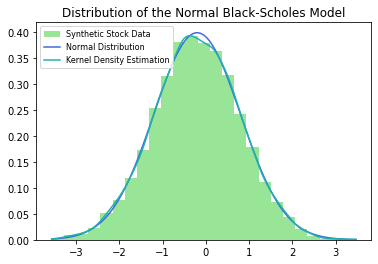

In [3]:
s0=100
T=1
mu = 0.3
sigma = 1
S=np.zeros(10000)

for i in range(len(S)):
    S[i]= np.log(GBM(mu,sigma,T,s0)/s0)


x = np.linspace(min(S), max(S), 200)
kde = stats.gaussian_kde(S)

plt.hist(S,bins=25,alpha=0.5,color='limegreen',density=True,label='Synthetic Stock Data')
plt.plot(x, norm.pdf(x, (mu - 1/2 * sigma**2)*T, sigma),label = 'Normal Distribution',color='royalblue')

plt.plot(x,kde(x),label = 'Kernel Density Estimation',color='lightseagreen')
plt.legend(loc=2,prop={'size': 8})
plt.title('Distribution of the Normal Black-Scholes Model')
plt.savefig('Images/GBMDistribution.png', dpi = 300)
plt.show()


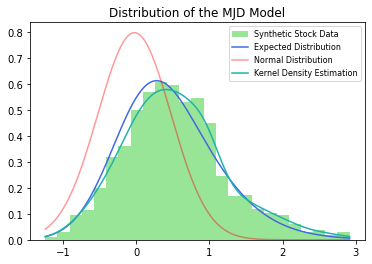

In [4]:
s0=350
T=1
mu = 0.1

S=np.zeros(1000)
lambda_jump = 0.7
mu_jump = 0.5  
sigma_jump = 0.3   
sigma=0.5
for i in range(len(S)):
    S[i]= np.log(GBM_MJD(mu,sigma,T,s0,lambda_jump,mu_jump,sigma_jump)/s0)


x = np.linspace(min(S), max(S), 200)
kde = stats.gaussian_kde(S)

plt.hist(S,bins=25,alpha=0.5,color='limegreen',density=True,label='Synthetic Stock Data')
plt.plot(x, Merton_pdf(x, T, mu, sigma, lambda_jump, mu_jump, sigma_jump),label = 'Expected Distribution',color='royalblue')
plt.plot(x,norm.pdf(x, (mu - 1/2 * sigma**2)*T, sigma),label = 'Normal Distribution',alpha=0.4,color='red')

plt.plot(x,kde(x),label = 'Kernel Density Estimation',color='lightseagreen')
plt.legend(loc=1,prop={'size': 8})
plt.title('Distribution of the MJD Model')
plt.savefig('Images/GBM_MJDDistribution.png', dpi = 300)
plt.show()


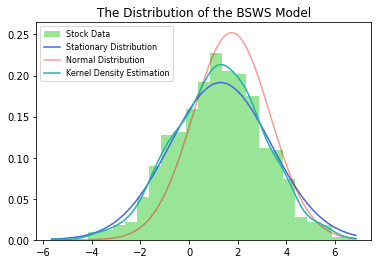

In [5]:
s0=100
T=10
mu = 0.3
sigmas=[0.1,1]
Q = np.array(([-8,8],[16,-16]))
S=np.zeros(1000)
sigma=0.5

for i in range(len(S)):
    S[i]= np.log(GBM_WS(mu,sigmas,T,s0,Q)/s0)
x = np.linspace(min(S), max(S), 100)
kde = stats.gaussian_kde(S)

mean1 = (mu - 1/2 * sigmas[0]**2) * T
mean2 = (mu - 1/2 * sigmas[1]**2) * T
sig1 =sigmas[0]*np.sqrt(T)
sig2 = sigmas[1]*np.sqrt(T)

plt.hist(S,bins=25,alpha=0.5,color='limegreen',density=True,label='Stock Data')
plt.plot(x, norm.pdf(x,mean1*2/3 +mean2*1/3, sig1*np.sqrt(2/3) + sig2*np.sqrt(1/3)), label='Stationary Distribution',color='royalblue')
plt.plot(x,norm.pdf(x, (mu - 1/2 * sigma**2)*T, sigma*np.sqrt(T)),label = 'Normal Distribution',alpha=0.4,color='red')

plt.plot(x,kde(x),label = 'Kernel Density Estimation',color='lightseagreen')
plt.legend(loc=2,prop={'size': 8})
plt.title('The Distribution of the BSWS Model')
plt.savefig('Images/GBM_WSDistribution.png', dpi = 300)
plt.show()


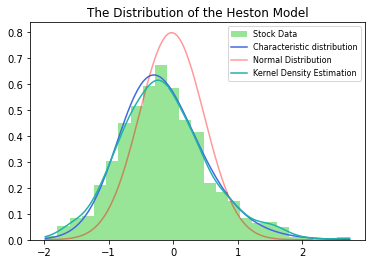

In [6]:
s0=350
T=1
mu = 0.1
S=np.zeros(1000)
sig0=0.5
delta = 1 #the rate it gets to sigma
theta = 0.5 #value it averages around
k=0.5 #vol of vol

for i in range(len(S)):
    S[i]= np.log(Stochastic_Volatility(mu,sig0,T,s0,delta,theta,k)/s0)

x = np.linspace(min(S), max(S), 200)
plt.hist(S,bins=25,alpha=0.5,color='limegreen',density=True,label='Stock Data')
plt.plot(x, [Heston_pdf(i, t=T, v0=sig0, mu=mu, theta=theta, sigma=sigma, kappa=k, rho=0.6) for i in x],label = 'Characteristic distribution', color='royalblue')
plt.plot(x,norm.pdf(x, (mu - 1/2 * sigma**2)*T, sigma),label = 'Normal Distribution',alpha=0.4,color='red')

kde = stats.gaussian_kde(S)

plt.plot(x,kde(x),label = 'Kernel Density Estimation',color='lightseagreen')
plt.legend(loc=1,prop={'size': 8})
plt.title('The Distribution of the Heston Model')
plt.savefig('Images/GBM_Heston_Distribution.png', dpi = 300)
plt.show()
